**LIBERERIAS**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA

In [3]:
import sys
!{sys.executable} -m pip install --upgrade "threadpoolctl>=3"

**DATA**

In [5]:
file_path   = "Data_Set_Global.xlsx"   # ← Ajusta la ruta si cambia
pedidos     = pd.read_excel(file_path, sheet_name="Pedidos")

**ANÁLISIS PRELIMINARES**

 ------------------------------------------------------------
# 1. Vistazo general y limpieza mínima
 ------------------------------------------------------------

In [8]:
print(pedidos.info())
# Valores faltantes (%)
print((pedidos.isnull().mean()*100).sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   order_id                5000 non-null   int64         
 1   product_id              5000 non-null   int64         
 2   quantity                5000 non-null   int64         
 3   unit_price              5000 non-null   float64       
 4   customer_id             5000 non-null   int64         
 5   order_date              5000 non-null   datetime64[ns]
 6   promised_delivery_time  5000 non-null   datetime64[ns]
 7   actual_delivery_time    5000 non-null   datetime64[ns]
 8   delivery_status         5000 non-null   object        
 9   order_total             5000 non-null   float64       
 10  payment_method          5000 non-null   object        
 11  delivery_partner_id     5000 non-null   int64         
 12  store_id                5000 non-null   int64   

In [9]:
display(pedidos.head())

,order_id,product_id,quantity,unit_price,customer_id,order_date,promised_delivery_time,actual_delivery_time,delivery_status,order_total,...,total_orders,avg_order_value,first_name,gender,product_name,mrp,margin_percentage,shelf_life_days,min_stock_level,max_stock_level
0,1001453982,557908,3,942.37,34668988,2023-07-31 04:57:56,2023-07-31 05:13:56,2023-07-31 05:24:56,Slightly Delayed,2774.06,...,3,534.37,Wishi,Male,Vitamins,1177.96,20,365,14,53
1,1001900652,217710,2,58.59,30367559,2024-09-08 20:08:07,2024-09-08 20:19:07,2024-09-08 20:32:07,Slightly Delayed,1456.96,...,6,1419.60,Bhavna,Female,Eggs,73.24,20,7,19,53
2,1002438039,709916,3,33.76,85198177,2024-02-17 03:28:02,2024-02-17 03:44:02,2024-02-17 03:43:02,On Time,3775.99,...,6,1666.01,Charita,Female,Detergent,45.01,25,365,30,88
3,1002526452,444361,2,822.63,97475543,2023-07-31 23:19:05,2023-07-31 23:29:05,2023-07-31 23:33:05,On Time,5001.82,...,13,451.92,Niharika,Female,Pain Reliever,1028.29,20,365,20,71
4,1008158736,721521,1,417.39,62971413,2024-06-10 15:00:16,2024-06-10 15:14:16,2024-06-10 15:23:16,Slightly Delayed,814.33,...,18,835.09,Baljiwan,Male,Rice,491.05,15,365,20,72


 ------------------------------------------------------------
# 2. Feature engineering útil para el análisis
 ------------------------------------------------------------

In [11]:

pedidos["total_price"]      = pedidos["quantity"] * pedidos["unit_price"]
pedidos["order_date"]       = pd.to_datetime(pedidos["order_date"])
pedidos["promised_delivery_time"] = pd.to_datetime(pedidos["promised_delivery_time"])
pedidos["actual_delivery_time"]   = pd.to_datetime(pedidos["actual_delivery_time"])

pedidos["delivery_delay_min"] = (
    (pedidos["actual_delivery_time"] - pedidos["promised_delivery_time"])
    .dt.total_seconds() / 60
)


 ------------------------------------------------------------
# 3. Estadísticos descriptivos rápidos
 ------------------------------------------------------------

In [13]:
display(pedidos.describe().T)

,count,mean,min,25%,50%,75%,max,std
order_id,5000.0,5029129224.1876,60465.0,2531420519.25,5074377551.0,7488578761.0,9998297778.0,2863532520.894328
product_id,5000.0,509974.9396,4452.0,257719.0,540618.0,747801.0,993331.0,293678.307475
quantity,5000.0,2.0068,1.0,1.0,2.0,3.0,3.0,0.820542
unit_price,5000.0,493.1579,12.32,227.22,448.16,781.08,995.98,298.075647
customer_id,5000.0,50096845.2234,31813.0,24043135.0,49978078.5,76212152.0,99893898.0,29190820.314659
order_date,5000,2024-01-09 00:36:06.259200,2023-03-16 08:10:44,2023-08-17 01:54:09.249999872,2024-01-07 11:35:32,2024-06-03 20:53:15.750000128,2024-11-04 20:29:15,NaN
promised_delivery_time,5000,2024-01-09 00:51:05.743200,2023-03-16 08:27:44,2023-08-17 02:13:24.249999872,2024-01-07 11:47:02,2024-06-03 21:09:30.750000128,2024-11-04 20:43:15,NaN
actual_delivery_time,5000,2024-01-09 00:55:32.323200,2023-03-16 08:24:44,2023-08-17 02:27:24.249999872,2024-01-07 11:51:02,2024-06-03 21:09:30.750000128,2024-11-04 20:47:15,NaN
order_total,5000.0,2201.8617,13.25,1086.215,2100.69,3156.8825,6721.46,1303.02438
delivery_partner_id,5000.0,50050.3182,43.0,24928.5,50262.5,74478.25,99968.0,28802.276922


------------------------------------------------------------
# 4. Correlación de variables numéricas
------------------------------------------------------------

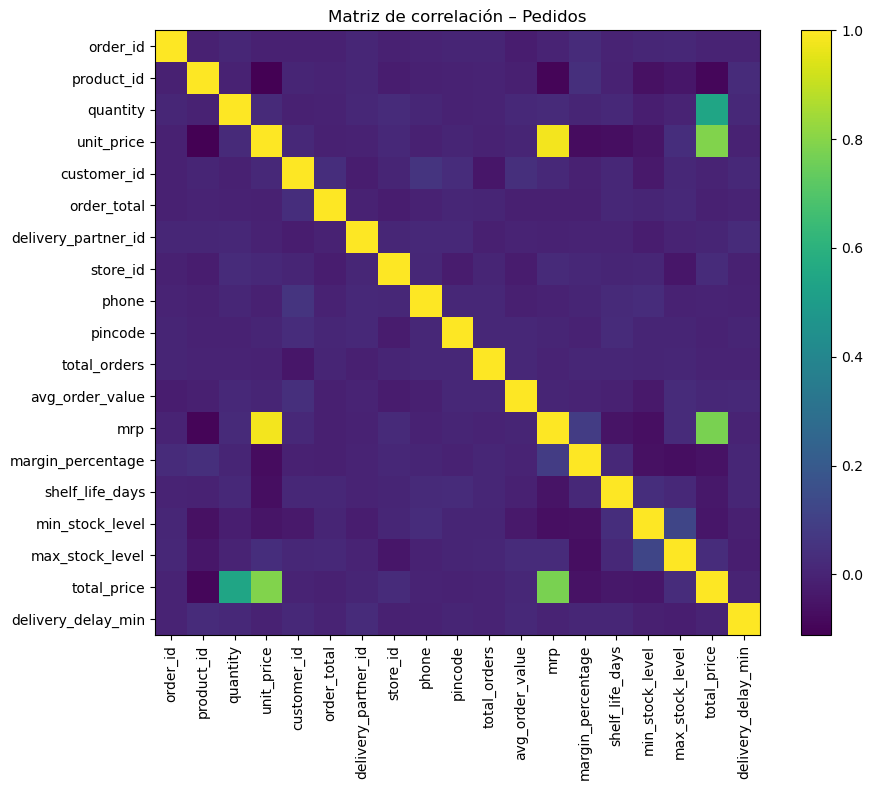

In [15]:
num_cols = pedidos.select_dtypes("number").columns
corr     = pedidos[num_cols].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, interpolation='none')     # Sin especificar colores
plt.title("Matriz de correlación – Pedidos")
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.tight_layout()
plt.show()

------------------------------------------------------------
# 5. Scatter-matrix (relaciones pares selecionados)
------------------------------------------------------------

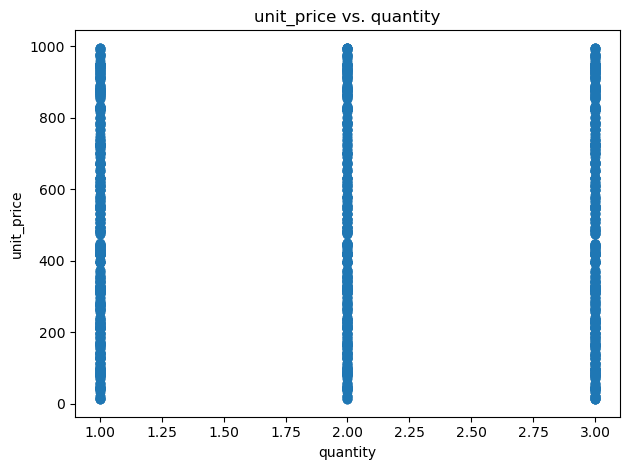

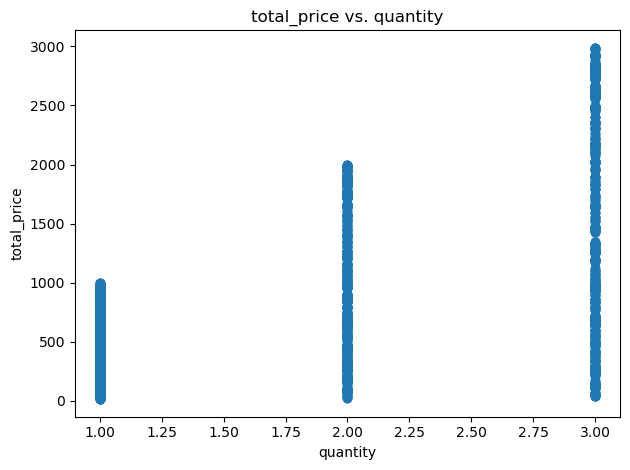

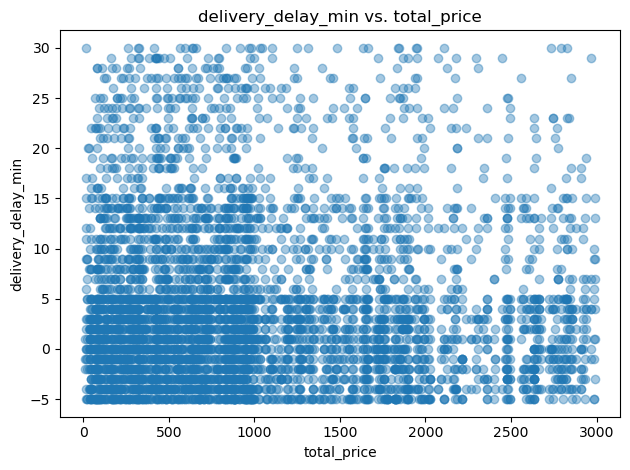

In [17]:

pairs = [("quantity", "unit_price"),
         ("quantity", "total_price"),
         ("total_price", "delivery_delay_min")]

for x, y in pairs:
    plt.figure()
    plt.scatter(pedidos[x], pedidos[y], alpha=0.4)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{y} vs. {x}")
    plt.tight_layout()
    plt.show()

**PREPARACIÓN PARA EL CLUSTER**

------------------------------------------------------------
# 6. Métricas agregadas por cliente
------------------------------------------------------------

In [20]:
agg = (
    pedidos
    .groupby("customer_id")
    .agg(
        total_orders    = ("order_id", "nunique"),
        avg_order_value = ("total_price", "mean"),
        first_order     = ("order_date", "min"),
        last_order      = ("order_date", "max")
    )
    .reset_index()
)

# Añadimos columnas ya presentes en el propio DataFrame
cols_extra = ["registration_date", "customer_segment", "gender"]
agg = agg.merge(
    pedidos[["customer_id"] + cols_extra].drop_duplicates("customer_id"),
    on="customer_id",
    how="left"
)

print("=== Tabla agregada por cliente ===")
print(agg.head())


=== Tabla agregada por cliente ===
   customer_id  total_orders  avg_order_value         first_order  \
0        31813             2      2076.525000 2024-07-11 03:32:42   
1        61020             3      1041.636667 2023-05-10 15:23:10   
2       119099             4       418.750000 2023-06-23 06:31:41   
3       188838             2       958.220000 2023-04-25 04:28:16   
4       191616             2       819.015000 2023-03-20 03:14:16   

           last_order registration_date customer_segment  gender  
0 2024-10-10 13:10:15        2024-04-10          Regular    Male  
1 2024-08-31 14:07:08        2024-07-27              New    Male  
2 2024-05-24 16:36:21        2023-08-01         Inactive    Male  
3 2024-02-19 14:40:22        2024-07-16         Inactive  Female  
4 2024-05-24 07:26:24        2023-04-27          Regular    Male  


------------------------------------------------------------
# 7. Customer_id ↔ payment_method
------------------------------------------------------------

In [22]:
# ============================================================
# 2. customer_id ↔ payment_method
# ============================================================
pay_tbl = (
    pedidos
    .groupby(["customer_id", "payment_method"])
    .size()
    .unstack(fill_value=0)
)
print("\n=== Frecuencia de payment_method por cliente ===")
display (pay_tbl)


=== Frecuencia de payment_method por cliente ===


payment_method,Card,Cash,UPI,Wallet
customer_id,,,,
31813,0,0,1,1
61020,1,1,0,1
119099,1,0,2,1
188838,0,1,1,0
191616,1,1,0,0
...,...,...,...,...
99734256,0,1,0,2
99772709,1,1,0,1
99784559,0,1,0,0


------------------------------------------------------------
# 8. Gráficas de métricas agregadas por cliente
------------------------------------------------------------

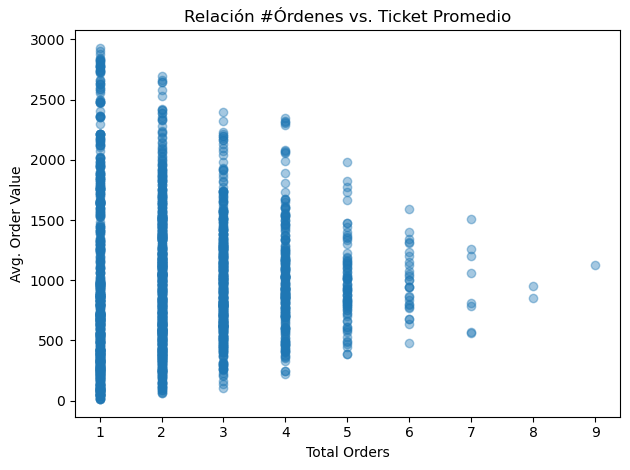

In [24]:
# ============================================================
# 3. (Scatter) total_orders vs. avg_order_value
# ============================================================
plt.figure()
plt.scatter(agg["total_orders"], agg["avg_order_value"], alpha=0.4)
plt.xlabel("Total Orders")
plt.ylabel("Avg. Order Value")
plt.title("Relación #Órdenes vs. Ticket Promedio")
plt.tight_layout()
plt.show()

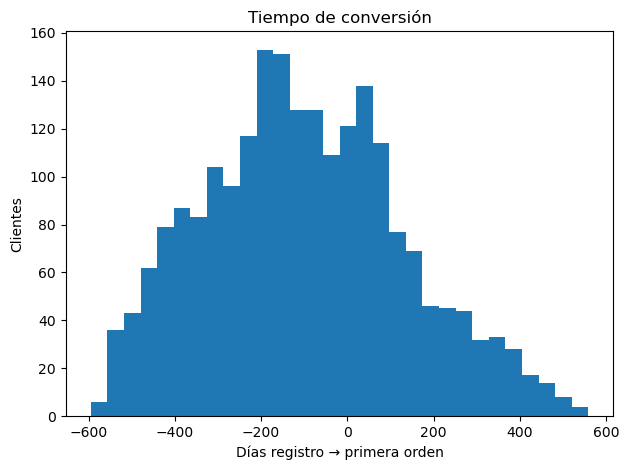

In [25]:
# ============================================================
# 5. (Hist) días desde registro hasta 1.ª compra
# ============================================================
agg["days_to_first"] = (
    agg["first_order"] - agg["registration_date"]
).dt.days

plt.figure()
plt.hist(agg["days_to_first"].dropna(), bins=30)
plt.xlabel("Días registro → primera orden")
plt.ylabel("Clientes")
plt.title("Tiempo de conversión")
plt.tight_layout()
plt.show()


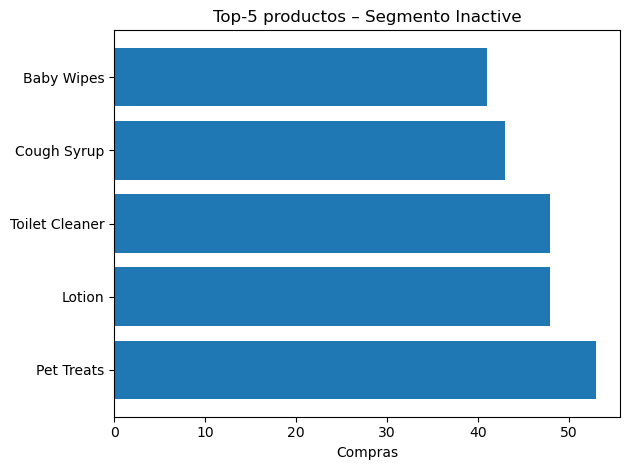

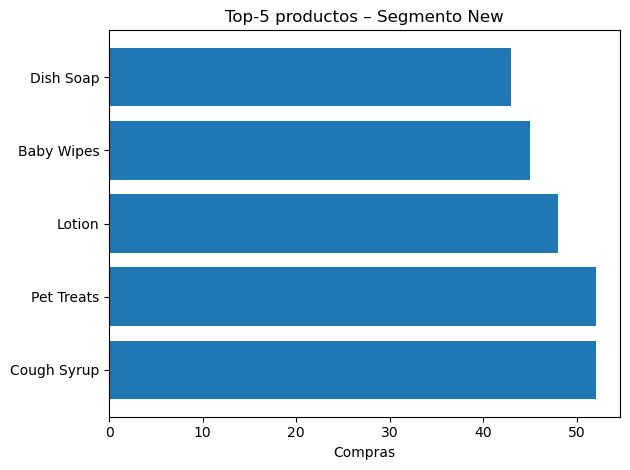

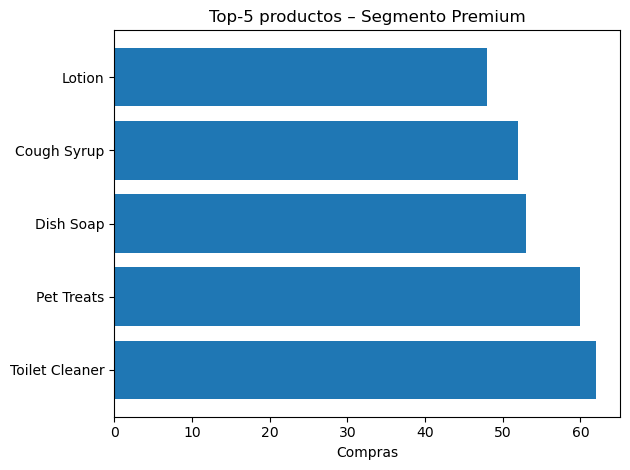

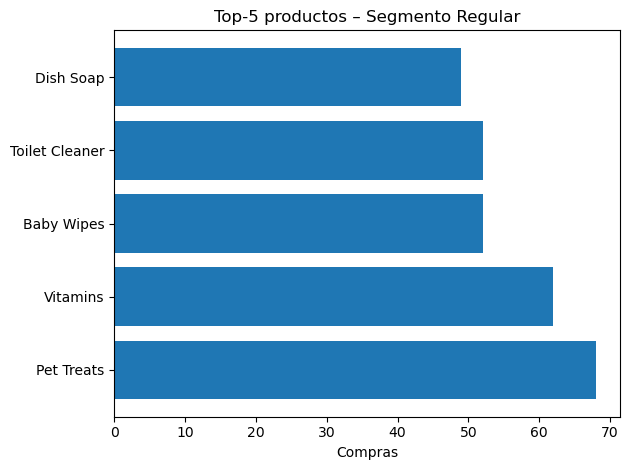

In [26]:
# ============================================================
# 1. Top-N productos por segmento
# ============================================================
N = 5  # cambia a 10 si quieres más
topN = (
    pedidos.groupby(["customer_segment", "product_name"])
       .size()
       .groupby(level=0, group_keys=False)
       .nlargest(N)
       .reset_index(name="compras")
)

for seg in topN["customer_segment"].unique():
    df = topN[topN["customer_segment"] == seg]
    plt.figure()
    plt.barh(df["product_name"], df["compras"])
    plt.title(f"Top-{N} productos – Segmento {seg}")
    plt.xlabel("Compras")
    plt.tight_layout()
    plt.show()

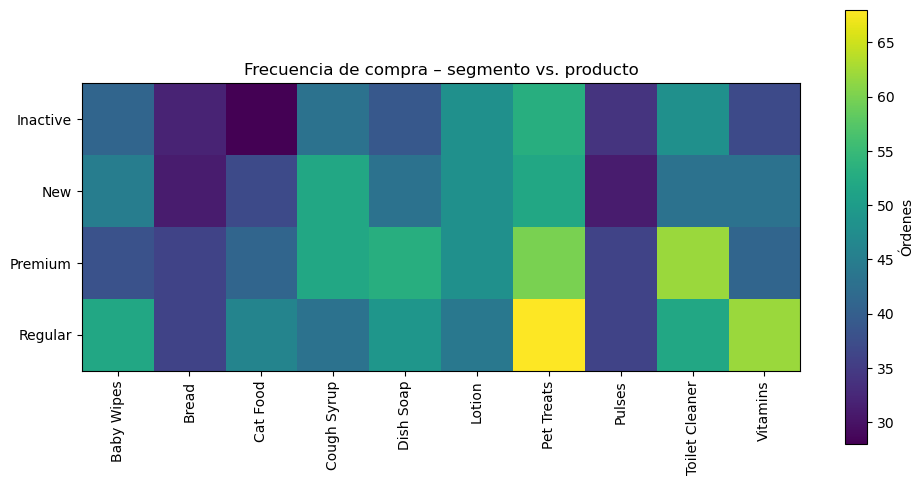

In [27]:
# ============================================================
# 2. Heat-map sencillo: segmento vs. producto (frecuencias)
#    *Matriz grande → filtra productos más populares*
# ============================================================
pop_prod = (
    pedidos["product_name"].value_counts()
       .head(10)             # 10 productos + vendidos
       .index
)

pivot = (
    pedidos[pedidos["product_name"].isin(pop_prod)]
      .pivot_table(index="customer_segment",
                   columns="product_name",
                   values="order_id",
                   aggfunc="count",
                   fill_value=0)
)

plt.figure(figsize=(10,5))
plt.imshow(pivot, interpolation='none')
plt.title("Frecuencia de compra – segmento vs. producto")
plt.colorbar(label="Órdenes")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=90)
plt.yticks(range(len(pivot.index)),  pivot.index)
plt.tight_layout()
plt.show()


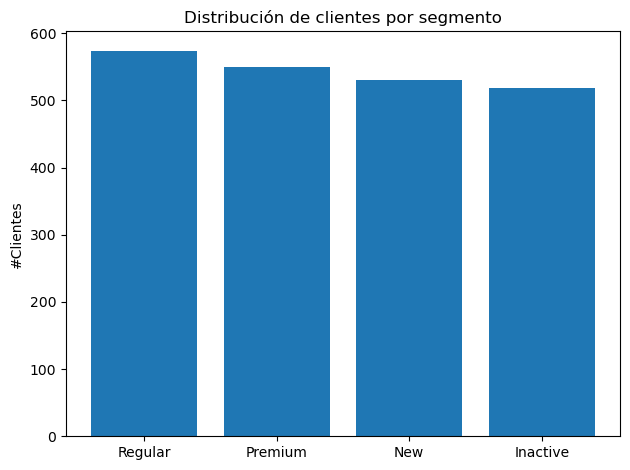

In [28]:
# ============================================================
# 3. Distribución de segmentos por #clientes
# ============================================================
seg_counts = pedidos[["customer_id", "customer_segment"]] \
               .drop_duplicates()["customer_segment"] \
               .value_counts()

plt.figure()
plt.bar(seg_counts.index, seg_counts.values)
plt.title("Distribución de clientes por segmento")
plt.ylabel("#Clientes")
plt.tight_layout()
plt.show()

------------------------------------------------------------
# 9. Análisis y métricas para los cluster
------------------------------------------------------------

| Análisis                                    | ¿Qué aporta?                                               | Código clave                                                                                               |
| ------------------------------------------- | ---------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------- |
| **RFM** (Recency–Frequency–Monetary)        | Marco clásico de segmentación; fácil de interpretar.       | Calcular `recencia` (días desde última compra), `frecuencia` (`total_orders`), `monetary` (`total_spent`). |
| **Cohorts** (mes registro vs. retención)    | Ver qué cohortes retienen mejor → feature de *tenure*.     | `pd.Grouper(freq="M")` + supervivencia.                                                                    |
| **Entrega a tiempo (%)**                    | KPI de logística por cliente; puede explicar churn.        | `(pedidos["delivery_delay_min"]<=0).mean()` agrupado.                                                      |
| **Embeddings de producto** (Word2Vec / NMF) | Capturar similitud de carrito sin crear miles de columnas. | Usar secuencias de `product_id` por orden.                                                                 |
| **Método de pago diversidad (entropía)**    | Clientes multi-método vs monométodo.                       | `scipy.stats.entropy` sobre distribución de pago por cliente.                                              |
| **Gráfica de codo + silhouette**            | Determinar #clúster óptimo.                                | `KMeans` + métricas.                                                                                       |


------------------------------------------------------------
## 9.1 Entropía de métodos de pago por cliente
------------------------------------------------------------

In [32]:
from scipy.stats import entropy
import pandas as pd

# Conteo de cada método de pago por cliente
pay_counts = (
    pedidos.groupby(["customer_id", "payment_method"])
           .size()
           .unstack(fill_value=0)
)

# Probabilidad (distribución) por fila
pay_probs = pay_counts.div(pay_counts.sum(axis=1), axis=0)

# Entropía base-2 (0 = un solo método; máximo = uso equitativo de todos)
payment_entropy = pay_probs.apply(lambda row: entropy(row, base=2), axis=1)

customer_payment_diversity = payment_entropy.rename("payment_entropy").reset_index()

display(customer_payment_diversity)

,customer_id,payment_entropy
0,31813,1.000000
1,61020,1.584963
2,119099,1.500000
3,188838,1.000000
4,191616,1.000000
...,...,...
2167,99734256,0.918296
2168,99772709,1.584963
2169,99784559,0.000000
2170,99824171,1.000000


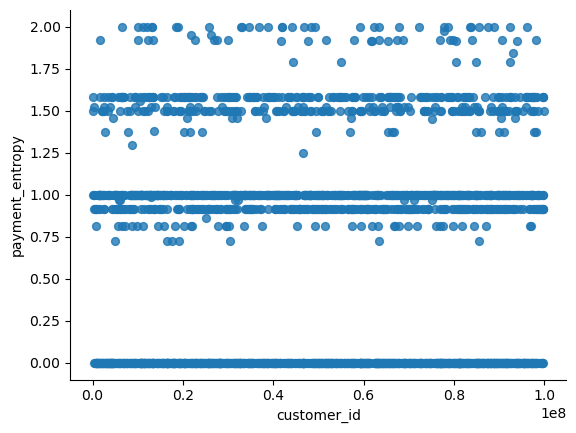

In [33]:
customer_payment_diversity.plot(kind='scatter', x='customer_id', y='payment_entropy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [34]:
!pip install numpy==1.24.0 gensim==4.3.0 scipy==1.10.1

------------------------------------------------------------
## 9.2 Embeddings de producto
------------------------------------------------------------

**secuencias de productos comprados en la misma orden**

In [37]:
# ============================================================
# 9.2a. Word2Vec de productos
# ============================================================
import gensim
import pandas as pd

# ❶ Lista de 'sentencias' (cada orden = lista de productos)
sentences = (
    pedidos.sort_values("order_id")
           .groupby("order_id")["product_name"]
           .apply(list)
           .tolist()
)

# ❷ Entrena Word2Vec
w2v = gensim.models.Word2Vec(
        sentences      = sentences,
        vector_size    = 50,     # dimensión del embedding
        window         = 5,
        min_count      = 5,      # ignora productos muy raros
        workers        = 4,
        seed           = 42
     )

# ❸ Embedding como DataFrame
product_vectors = pd.DataFrame(
    w2v.wv.vectors,
    index = w2v.wv.index_to_key
)


In [38]:
display(product_vectors)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Pet Treats,-0.016430,0.010958,0.006183,-0.002445,-0.002679,0.014344,-0.016562,0.007895,-0.011941,-0.016233,...,-0.013391,0.010324,0.008021,-0.005819,-0.017283,0.018828,-0.002173,0.015725,0.007117,0.011135
Toilet Cleaner,0.010396,-0.012214,-0.005444,-0.001331,-0.000088,-0.018248,0.001863,-0.013828,0.009735,0.007322,...,-0.002591,0.012191,0.013668,-0.004501,0.015924,-0.008467,-0.010418,0.007300,0.005470,-0.014410
Cough Syrup,0.013309,-0.012004,0.012196,-0.019706,0.011874,0.011477,0.011215,0.006594,-0.001137,0.008207,...,0.019310,-0.011417,-0.008938,-0.003659,0.019707,0.014136,-0.018612,-0.010642,0.012867,-0.017668
Lotion,0.014227,-0.008745,0.016706,-0.008256,-0.002627,0.006477,-0.014949,0.002281,0.000201,0.011356,...,0.007348,0.005211,0.004288,-0.005527,0.018388,-0.016494,-0.006296,-0.015280,-0.006442,0.018476
Dish Soap,-0.005349,0.016343,-0.000197,0.007988,-0.001703,-0.009365,0.010569,0.018767,-0.009459,0.011150,...,-0.014391,0.003364,-0.016212,0.005994,0.005150,-0.016622,0.010300,-0.003368,0.011475,-0.018335
Vitamins,-0.012822,-0.000240,-0.012471,-0.006806,0.006424,-0.014219,0.007108,-0.015864,-0.012993,0.003506,...,0.012304,-0.009321,0.018151,-0.006737,0.001800,0.000827,0.013991,-0.002444,-0.008618,-0.019136
Baby Wipes,-0.005453,0.013052,-0.019603,0.015846,0.001713,-0.014390,-0.007913,0.002161,-0.007372,-0.015657,...,0.005393,-0.008363,0.004874,0.000602,0.016221,-0.009761,0.019655,0.017442,-0.012772,-0.013416
Cat Food,0.001326,-0.018204,-0.008048,-0.002596,0.018775,0.019695,-0.013938,0.015667,-0.016363,0.009944,...,0.009870,-0.012829,-0.005312,0.003975,0.008797,0.014982,-0.018209,-0.012143,-0.008780,-0.007587
Pulses,0.019921,0.011096,-0.007183,0.018873,-0.000028,0.000030,-0.002652,-0.014244,0.017375,-0.019443,...,0.018925,-0.007962,-0.014711,-0.000457,0.000335,0.006515,-0.007450,0.018225,0.000841,-0.008542
Bread,0.018411,0.016992,-0.000033,-0.019006,0.003877,0.002208,-0.014072,0.005359,0.013632,-0.015764,...,0.017329,0.014710,0.010134,0.004124,-0.008406,-0.003497,-0.015244,-0.005033,0.017059,-0.002965


**Matriz cliente × producto**

In [40]:
# ============================================================
# 3b. NMF de cliente × producto
# ============================================================
from sklearn.decomposition import NMF
import pandas as pd # Import pandas if not already imported in this cell

# ❶ Matriz de conteo
cust_prod = (
    pedidos.groupby(["customer_id", "product_id"])
           .size()
           .unstack(fill_value=0)
)

# ❷ NMF
K = 20                # nº de tópicos/latent factors
nmf = NMF(n_components=K, init="random", random_state=42)
W = nmf.fit_transform(cust_prod)    # clientes × K
H = nmf.components_                 # K × productos

customer_topics = pd.DataFrame(W,
                               index   = cust_prod.index,
                               columns = [f"topic_{i+1}" for i in range(K)])

product_topics  = pd.DataFrame(H,
                               columns = cust_prod.columns,
                               index   = [f"topic_{i+1}" for i in range(K)])

print(customer_topics.head())
print(product_topics.iloc[:3, :10])  # primeros 3 tópicos, 10 productos

              topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
customer_id                                                               
31813        0.111012  0.000000  0.270088  0.000000  0.067619  0.032063   
61020        0.000000  0.441626  0.163500  0.000000  0.000000  0.045994   
119099       0.009280  0.007894  0.000000  0.098912  0.163906  0.000515   
188838       0.000000  0.000000  1.107763  0.000000  0.000000  0.000000   
191616       0.189272  0.097076  0.117141  0.017882  0.000582  0.045204   

              topic_7   topic_8   topic_9  topic_10  topic_11  topic_12  \
customer_id                                                               
31813        0.000000  0.000000  0.000000  0.017284  0.006912  0.023354   
61020        0.026624  0.006854  0.000000  0.000000  0.012824  0.164524   
119099       0.000000  0.018829  0.046141  0.079080  0.076508  0.038387   
188838       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
191616       0.000000  0

**Interpretación Afinidad de Cliente**

In [42]:
# Calculate the top topic index for each customer based on numerical topic columns
customer_topics["top_topic"] = customer_topics.filter(like="topic_").idxmax(axis=1)

# Calculate the maximum weight for each customer using only numerical topic columns
customer_topics["top_weight"] = customer_topics.filter(like="topic_").max(axis=1)


# Clientes especializados (>0.7 en su tópico líder)
especializados = customer_topics[customer_topics["top_weight"] > 0.7]

In [43]:
display(especializados)

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,top_topic,top_weight
customer_id,,,,,,,,,,,,,,,,,,,,,
188838,0.000000,0.000000,1.107763,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.354835,0.000000,0.000000,0.000000,topic_3,1.107763
376144,0.000000,0.000000,0.000000,2.449635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.011752,0.014170,0.000000,0.000000,topic_4,2.449635
701493,0.000000,0.112438,0.000000,0.000000,0.000000,0.013779,0.000000,0.000000,0.000000,1.032938,...,0.0,0.023213,0.008629,0.000000,0.000000,0.000000,0.000000,0.010770,topic_10,1.032938
1174162,0.000000,0.000000,0.000000,0.000000,0.003751,0.000000,0.764143,0.000000,0.008414,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,topic_7,0.764143
1342184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.931965,...,0.0,0.030922,0.000000,0.047192,0.000000,0.000000,0.000000,0.000000,topic_10,0.931965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97492493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.775111,0.000000,0.000000,0.033165,0.028421,0.000000,0.000000,topic_14,0.775111
97770901,0.000000,0.015310,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.012785,0.000000,0.106068,0.000000,0.002091,0.727100,0.000000,topic_19,0.727100
98088303,0.127168,0.000000,0.000000,0.000000,0.000000,0.000000,1.161285,0.000000,0.004964,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.010294,0.000000,0.148613,topic_7,1.161285


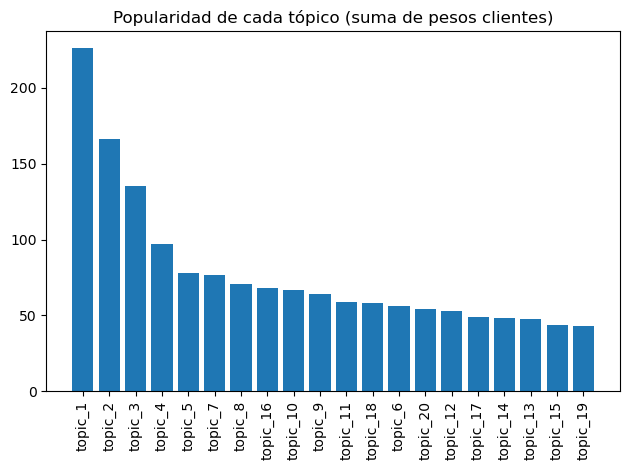

In [44]:
topic_popularity = customer_topics.iloc[:, :K].sum().sort_values(ascending=False)
plt.figure()
plt.bar(topic_popularity.index, topic_popularity.values)
plt.xticks(rotation=90)
plt.title("Popularidad de cada tópico (suma de pesos clientes)")
plt.tight_layout()
plt.show()

------------------------------------------------------------
## 9.3 Recency, Frequency, Monetary (RFM ANÁLISIS)
------------------------------------------------------------

In [46]:
# ============================================================
# 9. RFM Analysis
# ============================================================
import datetime as dt
from sklearn.preprocessing import StandardScaler

# Calculate Recency, Frequency, Monetary
# Define a snapshot date as the day after the last order date
snapshot_date = pedidos["order_date"].max() + dt.timedelta(days=1)

rfm = pedidos.groupby("customer_id").agg(
    recency    = ("order_date", lambda date: (snapshot_date - date.max()).days),
    frequency  = ("order_id", "nunique"),
    monetary   = ("total_price", "sum")
)

# Apply Z-score standardization
scaler_rfm = StandardScaler()
rfm_z      = pd.DataFrame(scaler_rfm.fit_transform(rfm),
                          index   = rfm.index,
                          columns = rfm.columns + "_z") # Add _z suffix

print("=== RFM Z-scores ===")
print(rfm_z.head())


=== RFM Z-scores ===
             recency_z  frequency_z  monetary_z
customer_id                                    
31813        -1.159366    -0.242260    1.087910
61020        -0.903528     0.559856    0.487755
119099       -0.270327     1.361972   -0.358600
188838        0.337290    -0.242260   -0.217664
191616       -0.270327    -0.242260   -0.380180


------------------------------------------------------------
# 10. CLUSTER
------------------------------------------------------------

Liberías

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

------------------------------------------------------------
## 10.1 Reunir features en un solo DataFrame
------------------------------------------------------------

In [51]:
full_df = (
    rfm_z                                 # recency, frequency, monetary (z-score)
    .join(customer_payment_diversity.set_index("customer_id"))  # payment_entropy
    .join(customer_topics)                # topic_1 … topic_20
).fillna(0)

print("Matriz final:", full_df.shape)  # (n_clientes, n_features)

# Guardamos la llave para re-unir luego
customers = full_df.index

Matriz final: (2172, 26)


In [52]:
# ============================================================
# 1. Escalado
# ============================================================
scaler     = StandardScaler()

# Select only the numerical columns before scaling
# Or drop the non-numerical column explicitly
X_scaled   = scaler.fit_transform(full_df.select_dtypes(include=np.number))

------------------------------------------------------------
## 10.2 Seleccionar número óptimo de clúster 
------------------------------------------------------------

In [54]:
import threadpoolctl
print(threadpoolctl.__version__)  # debería mostrar 3.x

3.6.0


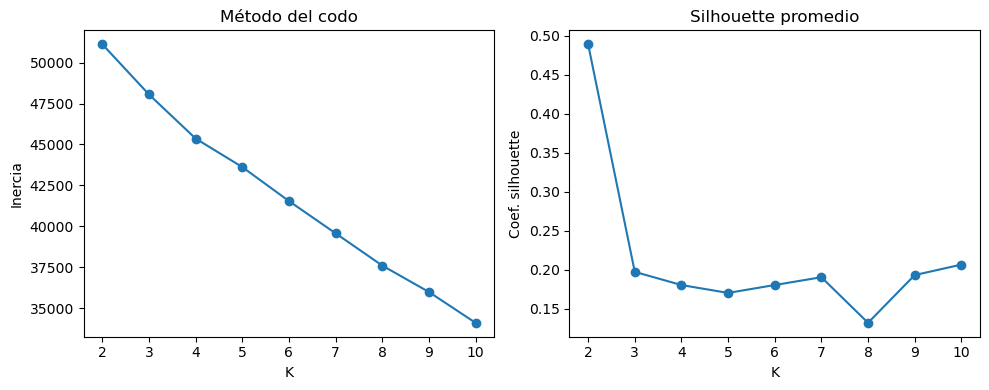

In [55]:
# ============================================================
# codo + silhouette
# ============================================================
Ks = range(2, 11)
inertia, silh = [], []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    silh.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(Ks, inertia, "-o")
plt.title("Método del codo")
plt.xlabel("K"); plt.ylabel("Inercia")

plt.subplot(1,2,2)
plt.plot(Ks, silh, "-o")
plt.title("Silhouette promedio")
plt.xlabel("K"); plt.ylabel("Coef. silhouette")

plt.tight_layout(); plt.show()

# Elige K (ejemplo: 5)
K_OPT = 5

------------------------------------------------------------
## 10.3 Clustering final con K óptimo
------------------------------------------------------------

In [57]:
# Elige K (ejemplo: 5)
K_OPT = 3

kmeans = KMeans(n_clusters=K_OPT, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X_scaled)

# Añadimos labels al DataFrame original
full_df["cluster"] = cluster_labels
full_df.index.name = "customer_id"

print(full_df.head())

             recency_z  frequency_z  monetary_z  payment_entropy   topic_1  \
customer_id                                                                  
31813        -1.159366    -0.242260    1.087910         1.000000  0.111012   
61020        -0.903528     0.559856    0.487755         1.584963  0.000000   
119099       -0.270327     1.361972   -0.358600         1.500000  0.009280   
188838        0.337290    -0.242260   -0.217664         1.000000  0.000000   
191616       -0.270327    -0.242260   -0.380180         1.000000  0.189272   

              topic_2   topic_3   topic_4   topic_5   topic_6  ...  topic_14  \
customer_id                                                    ...             
31813        0.000000  0.270088  0.000000  0.067619  0.032063  ...  0.000000   
61020        0.441626  0.163500  0.000000  0.000000  0.045994  ...  0.071916   
119099       0.007894  0.000000  0.098912  0.163906  0.000515  ...  0.000000   
188838       0.000000  1.107763  0.000000  0.000000  

## 10.4 Interpretación de topicos

In [59]:
# 2. Resumen de categorías por tópico
# ------------------------------------------------------------
TOP_N = 10
# Use the previously defined 'file_path' variable
prod_meta = pd.read_excel(file_path, sheet_name="Productos")
prod_meta = prod_meta.set_index("product_id")            # adapta la llave

for t in product_topics.index:
    # IDs de los TOP_N productos más pesados
    top_ids = (
        product_topics.loc[t]
        .sort_values(ascending=False)
        .head(TOP_N)
        .index
    )
    cats = prod_meta.loc[top_ids, "subcategory"].value_counts()

    print(f"\n{t} - categorías dominantes:")
    print(cats.head())          # las 3-5 primeras suelen bastar


topic_1 - categorías dominantes:
subcategory
Infant Hygiene             2
Nutritional Supplements    1
Proteins                   1
Frozen Meals               1
Dry Breakfast              1
Name: count, dtype: int64

topic_2 - categorías dominantes:
subcategory
Bakery               2
Pet Snacks           2
Proteins             1
Frozen Vegetables    1
Skin Care            1
Name: count, dtype: int64

topic_3 - categorías dominantes:
subcategory
Frozen Meals       3
Root Vegetables    1
Pet Food           1
Leafy Greens       1
Instant Meals      1
Name: count, dtype: int64

topic_4 - categorías dominantes:
subcategory
Bakery             2
Dairy              2
Root Vegetables    1
Infant Hygiene     1
Salty Snacks       1
Name: count, dtype: int64

topic_5 - categorías dominantes:
subcategory
Salty Snacks          3
Sweet Snacks          2
Basic Medication      1
Cooking Essentials    1
Natural Juices        1
Name: count, dtype: int64

topic_6 - categorías dominantes:
subcategory
Infa

In [60]:
# Diccionario con los nombres propuestos
topic_names = {
    "topic_1":  "Cuidado familiar & básicos",
    "topic_2":  "Mascotas & panadería",
    "topic_3":  "Comidas congeladas/preparadas",
    "topic_4":  "Panadería & lácteos funcionales",
    "topic_5":  "Snacks mixtos & cocina",
    "topic_6":  "Dulces & limpieza",
    "topic_7":  "Limpieza del hogar & verduras",
    "topic_8":  "Higiene personal & granos",
    "topic_9":  "Lácteos & alimentos mascota",
    "topic_10": "Limpieza & proteína mascota",
    "topic_11": "Limpieza, refrescos & granos",
    "topic_12": "Cocina dulce & infantil",
    "topic_13": "Snacks salados & OTC",
    "topic_14": "Snacks mascota & proteínas",
    "topic_15": "Higiene premium & lácteos",
    "topic_16": "Infantil & congelados",
    "topic_17": "Cuidado piel & mascota",
    "topic_18": "OTC & bebidas",
    "topic_19": "Proteínas frescas",
    "topic_20": "Verduras raíz & snacks pet"
}

# Renombrar columnas en customer_topics
customer_topics_named = customer_topics.rename(columns=topic_names)

# Reemplazar las antiguas columnas en full_df por las renombradas
full_df = (
    full_df.drop(columns=customer_topics.columns)   # quita topic_1 … topic_20
            .join(customer_topics_named)            # agrega las nuevas
)

print("Columnas actualizadas en full_df:")
print(full_df.columns.tolist())

Columnas actualizadas en full_df:
['recency_z', 'frequency_z', 'monetary_z', 'payment_entropy', 'cluster', 'Cuidado familiar & básicos', 'Mascotas & panadería', 'Comidas congeladas/preparadas', 'Panadería & lácteos funcionales', 'Snacks mixtos & cocina', 'Dulces & limpieza', 'Limpieza del hogar & verduras', 'Higiene personal & granos', 'Lácteos & alimentos mascota', 'Limpieza & proteína mascota', 'Limpieza, refrescos & granos', 'Cocina dulce & infantil', 'Snacks salados & OTC', 'Snacks mascota & proteínas', 'Higiene premium & lácteos', 'Infantil & congelados', 'Cuidado piel & mascota', 'OTC & bebidas', 'Proteínas frescas', 'Verduras raíz & snacks pet', 'top_topic', 'top_weight']


## 10.5 Perfil RFM + entropía + tópicos

In [62]:
# ============================================================
# 4. Perfil RFM + Entropía + Tópicos RENOMBRADOS
# ============================================================

# --- 4.1  Identificar columnas de tópicos (ya NO empiezan con "topic_") ---
topic_cols = [col for col in full_df.columns if col in topic_names.values()]

# --- 4.2  Columnas numéricas base (RFM + entropía) + tópicos ---
profile_cols = ["recency_z", "frequency_z", "monetary_z", "payment_entropy"] + topic_cols

# --- 4.3  Perfil promedio por clúster ---
cluster_profile = (
    full_df.groupby("cluster")[profile_cols]
           .mean()
           .round(2)
)

print("\n=== Medias por clúster (RFM · entropía · tópicos) ===")
display(cluster_profile)



=== Medias por clúster (RFM · entropía · tópicos) ===


,recency_z,frequency_z,monetary_z,payment_entropy,Cuidado familiar & básicos,Mascotas & panadería,Comidas congeladas/preparadas,Panadería & lácteos funcionales,Snacks mixtos & cocina,Dulces & limpieza,...,"Limpieza, refrescos & granos",Cocina dulce & infantil,Snacks salados & OTC,Snacks mascota & proteínas,Higiene premium & lácteos,Infantil & congelados,Cuidado piel & mascota,OTC & bebidas,Proteínas frescas,Verduras raíz & snacks pet
cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.47,0.85,0.73,1.22,0.19,0.13,0.10,0.07,0.05,0.04,...,0.04,0.04,0.04,0.04,0.03,0.05,0.01,0.04,0.03,0.04
1,0.36,-0.66,-0.55,0.31,0.04,0.04,0.03,0.03,0.02,0.01,...,0.02,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.01
2,-0.27,0.47,0.08,0.93,0.09,0.01,0.05,0.02,0.04,0.03,...,0.01,0.03,0.02,0.01,0.01,0.01,0.41,0.02,0.01,0.01


In [63]:
# ============================================================
# 5. TOP-3 TÓPICOS por clúster (con nombres legibles)
# ============================================================

# Si ya tienes `topic_names` definido como en el bloque anterior:
topic_cols = list(topic_names.values())            # ['Cuidado familiar & básicos', …]

# Extrae columnas de tópicos que realmente estén en cluster_profile
topic_cols = [c for c in topic_cols if c in cluster_profile.columns]

top_topics = (
    cluster_profile[topic_cols]                    # solo tópicos
                 .apply(lambda row: row.nlargest(3).index.tolist(), axis=1)
                 .rename("top_topics")
)

print("\n=== Top-3 tópicos por clúster ===")
print(top_topics)



=== Top-3 tópicos por clúster ===
cluster
0    [Cuidado familiar & básicos, Mascotas & panade...
1    [Cuidado familiar & básicos, Mascotas & panade...
2    [Cuidado piel & mascota, Cuidado familiar & bá...
Name: top_topics, dtype: object


| Tópico    | Categorías dominantes                              | Nombre sugerido                       | Razonamiento breve                                                                           |
| --------- | -------------------------------------------------- | ------------------------------------- | -------------------------------------------------------------------------------------------- |
| topic\_1  | Infant Hygiene, Cooking Essentials, Pet Snacks     | **Cuidado familiar & básicos**        | Mezcla de higiene infantil y despensa esencial con algo de snacks de mascota.                |
| topic\_2  | Pet Snacks, Bakery, Home Cleaning                  | **Mascotas & panadería**              | Fuerte en snacks de mascota y productos de panificación; limpieza como apoyo del hogar.      |
| topic\_3  | Frozen Meals, Instant Meals                        | **Comidas congeladas/preparadas**     | Predominan platos listos para consumir.                                                      |
| topic\_4  | Bakery, Dairy, Infant Hygiene, Supplements         | **Panadería & lácteos funcionales**   | Pan + lácteos y productos para niños/suplementos → “panadería saludable”.                    |
| topic\_5  | Salty Snacks, Sweet Snacks, Cooking Essentials     | **Snacks mixtos & cocina**            | Alta presencia de snacks dulces-salados y aceites/condimentos.                               |
| topic\_6  | Sweet Snacks, Home Cleaning                        | **Dulces & limpieza**                 | Golosinas acompañadas de artículos de aseo.                                                  |
| topic\_7  | Home Cleaning, Root Vegetables                     | **Limpieza del hogar & verduras**     | Combinación poco habitual → clientes que compran útiles de aseo y productos frescos básicos. |
| topic\_8  | Personal Hygiene, Grains                           | **Higiene personal & granos**         | Shampoo, jabones y básicos secos (arroz, lentejas).                                          |
| topic\_9  | Dairy, Pet Food, Sweet Snacks                      | **Lácteos & alimentos para mascotas** | Destaca la canasta “refrigerado + mascota”.                                                  |
| topic\_10 | Home Cleaning, Pet Food, Cooking Essentials        | **Limpieza & proteína mascota**       | Hogar + insumos de cocina + comida pet.                                                      |
| topic\_11 | Home Cleaning, Sodas, Grains                       | **Limpieza, refrescos & granos**      | Aseo del hogar y bebidas carbonatadas.                                                       |
| topic\_12 | Cooking Essentials, Sweet Snacks, Infant Nutrition | **Cocina dulce & infantil**           | Aceites/condimentos + golosinas + fórmulas infantiles.                                       |
| topic\_13 | Salty Snacks, Basic Medication                     | **Snacks salados & OTC**              | Aperitivos salados y medicamentos de mostrador.                                              |
| topic\_14 | Pet Snacks, Proteins, Sweet Snacks                 | **Snacks mascota & proteínas**        | Premios para mascota y carnes/proteicos para humano.                                         |
| topic\_15 | Personal Hygiene, Dairy, Supplements               | **Higiene premium & lácteos**         | Claro sesgo a cuidado personal de mayor valor y lácteos.                                     |
| topic\_16 | Infant Hygiene, Frozen Meals/Veggies               | **Infantil & congelados**             | Padres que compran pañales/cremas + comida congelada.                                        |
| topic\_17 | Skin Care, Pet Food                                | **Cuidado piel & mascota**            | Belleza/dermo-cosmética y comida pet.                                                        |
| topic\_18 | Basic Medication, Sodas, Dairy                     | **OTC & bebidas**                     | Medicamentos básicos combinados con refrescos/lácteos.                                       |
| topic\_19 | Proteins, Fresh Fruits                             | **Proteínas frescas**                 | Carnes, pescados y algo de fruta fresca.                                                     |
| topic\_20 | Root Vegetables, Pet Snacks                        | **Verduras raíz & snacks pet**        | Compradores de básicos frescos + premios mascota.                                            |


## 10.6 Resumen resultados del Cluster

In [66]:
summary = (
    cluster_profile[["recency_z","frequency_z","monetary_z","payment_entropy"]] # Use the Z-scored column names
    .join(top_topics)
    .reset_index()
)

print("\nResumen ejecutivo:")
display(summary)


Resumen ejecutivo:


,cluster,recency_z,frequency_z,monetary_z,payment_entropy,top_topics
0,0,-0.47,0.85,0.73,1.22,"[Cuidado familiar & básicos, Mascotas & panade..."
1,1,0.36,-0.66,-0.55,0.31,"[Cuidado familiar & básicos, Mascotas & panade..."
2,2,-0.27,0.47,0.08,0.93,"[Cuidado piel & mascota, Cuidado familiar & bá..."


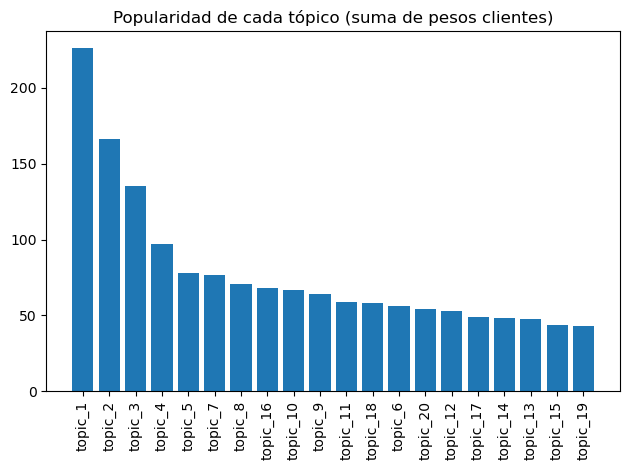

In [67]:
topic_popularity = customer_topics.iloc[:, :K].sum().sort_values(ascending=False)
plt.figure()
plt.bar(topic_popularity.index, topic_popularity.values)
plt.xticks(rotation=90)
plt.title("Popularidad de cada tópico (suma de pesos clientes)")
plt.tight_layout()
plt.show()


## 10.7 Análisis Gráfico

In [69]:
cluster_size = full_df["cluster"].value_counts().sort_index()
print("\nClientes por clúster:\n", cluster_size)



Clientes por clúster:
 cluster
0     901
1    1209
2      62
Name: count, dtype: int64


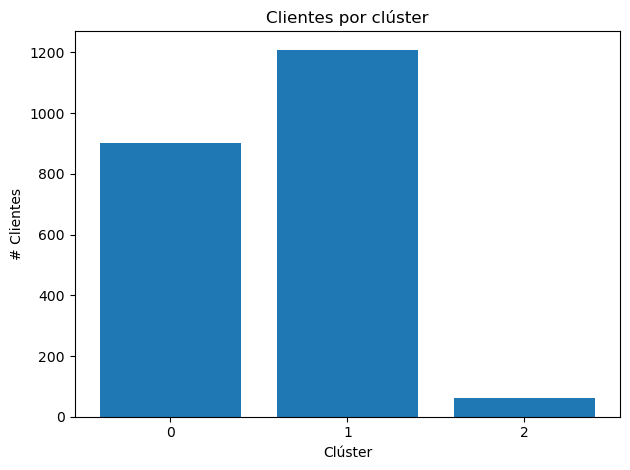

In [70]:
# 1) Barras: tamaño de cada cluster
cluster_size = full_df["cluster"].value_counts().sort_index()

plt.figure()
plt.bar(cluster_size.index.astype(str), cluster_size.values)
plt.title("Clientes por clúster")
plt.xlabel("Clúster")
plt.ylabel("# Clientes")
plt.tight_layout()
plt.show()

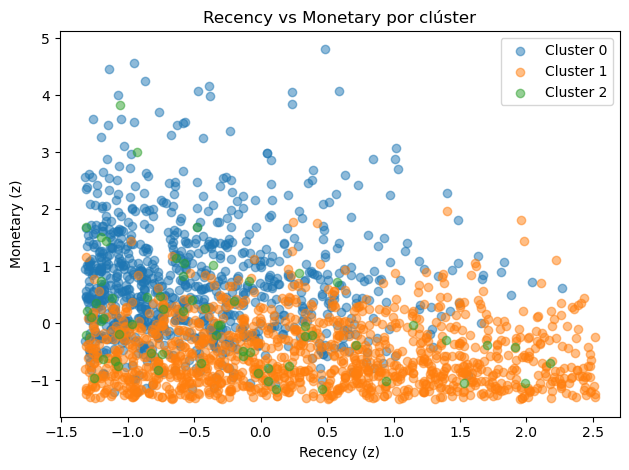

In [71]:
# 2) Scatter: Recency vs Monetary coloreado por cluster
plt.figure()
for c in sorted(full_df["cluster"].unique()):
    sub = full_df[full_df["cluster"] == c]
    plt.scatter(sub["recency_z"], sub["monetary_z"], alpha=0.5, label=f"Cluster {c}")
plt.xlabel("Recency (z)")
plt.ylabel("Monetary (z)")
plt.title("Recency vs Monetary por clúster")
plt.legend()
plt.tight_layout()
plt.show()

In [72]:
# ============================================================
# 5. TOP-3 TÓPICOS por clúster (nombres “human friendly”)
# ============================================================

# --- 5.1  Detectar automáticamente las columnas de tópicos ----------
rfm_cols = ["recency_z", "frequency_z", "monetary_z", "payment_entropy"]
topic_cols = [c for c in cluster_profile.columns if c not in rfm_cols]

# --- 5.2  Obtener los 3 de mayor peso en cada clúster ---------------
top_topics = (
    cluster_profile[topic_cols]
      .apply(lambda row: row.nlargest(3).index.tolist(), axis=1)
      .rename("top_topics")
)

print("\n=== Top-3 tópicos por clúster ===")
print(top_topics)



=== Top-3 tópicos por clúster ===
cluster
0    [Cuidado familiar & básicos, Mascotas & panade...
1    [Cuidado familiar & básicos, Mascotas & panade...
2    [Cuidado piel & mascota, Cuidado familiar & bá...
Name: top_topics, dtype: object


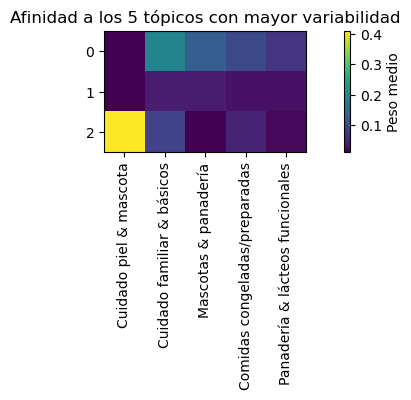

In [73]:
# ============================================================
# 4) Heat-map: afinidad a los 5 tópicos más “discriminantes”
#     (con los nombres legibles ya asignados)
# ============================================================

# --- 4.1  Identificar columnas de tópicos -------------------
rfm_cols   = ["recency_z", "frequency_z", "monetary_z", "payment_entropy"]
topic_cols = [c for c in cluster_profile.columns if c not in rfm_cols]

# --- 4.2  Seleccionar los 5 tópicos con mayor varianza entre clústeres
topic_var        = cluster_profile[topic_cols].var().sort_values(ascending=False)
top_topic_cols   = topic_var.head(5).index

# --- 4.3  Heat-map de afinidad --------------------------------------
heat = cluster_profile[top_topic_cols]

plt.figure(figsize=(8, 4))
plt.imshow(heat, interpolation="none")
plt.colorbar(label="Peso medio")
plt.xticks(range(len(heat.columns)), heat.columns, rotation=90)
plt.yticks(range(len(heat.index)),  heat.index)
plt.title("Afinidad a los 5 tópicos con mayor variabilidad")
plt.tight_layout()
plt.show()


| Clúster | Recency \_z | Frequency \_z | Monetary \_z  | Entropía pago | Lectura básica                                                                                                         |
| ------- | ----------- | ------------- | ------------- | ------------- | ---------------------------------------------------------------------------------------------------------------------- |
| **0**   | **–0.46**   | \*\* 0.74\*\* | \*\* 0.63\*\* | **1.20**      | **“Champions conveniencia”** → compran *hace poco*, con *alta frecuencia* y *ticket alto*. Usan varios medios de pago. |
| **1**   | +0.43       | **–0.72**     | **–0.62**     | 0.23          | **“Dormant básicos”** → antiguos, compran poco y barato; método de pago casi único.                                    |
| **2**   | –0.28       | 0.44          | 0.05          | 0.92          | **“Multi-topic moderados”** → recientes, frecuencia/media, ticket medio, cierta sofisticación digital.                 |
| **3**   | –0.29       | \*\* 0.64\*\* | \*\* 0.69\*\* | 0.99          | **“Familias high-value”** → comportamiento parecido al cl. 0 pero con cesta más variada (familiar).                    |
| **4**   | 0.05        | 0.27          | 0.38          | 0.84          | **“Ocasionales premium”** → ni tan recientes ni tan frecuentes, pero gastan algo más y compran categorías premium.     |


| Tópico                         | Mayor en                           | Comentario                                                      |
| ------------------------------ | ---------------------------------- | --------------------------------------------------------------- |
| **Cuidado familiar & básicos** | cl. 3 (también leve en 1)          | Refuerza la idea de familias con lista de mercado completa.     |
| **Higiene premium & lácteos**  | cl. 4                              | Segmento interesado en productos de mayor valor agregado.       |
| **Mascotas & panadería**       | cl. 3, algo en 2                   | Compra de snacks de mascota y panificados: hogares con mascota. |
| **Cuidado piel & mascota**     | cl. 2                              | Consumidor que combina belleza y productos pet.                 |
| **Higiene personal & granos**  | baja en todos (poco discriminante) |                                                                 |
